# Evaluating the transformer architecture

- In this notebook the pre-trained models' chepoints are imported and the learning curves are initially plotted for comparison.
- Next, a statitstical analysis of the models' performance on the test dataset is examined. Specifically, the angular distance between the 'real' and 'repdicted' future DoAs of the next timestep for various trajectories in the test dataset is calculated.
- Finally the performance of the two models with different number of past DoA observations is examined.

In [1]:
import torch
from transformer_utils import *
from utility_functions import *
import matplotlib.pyplot as plt
# Device config
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Device: {device}")

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


### Import the small TNN model

In [ ]:
model_path = 'RESULTS/model_checkpoint_small_v1.pth'
batch_size = 64
additional_features_dim = 4
context_size = 2
d_model = 256
context_dim = d_model
input_dim = 2
nhead = 4
num_encoder_layers = 3
dropout = 0.00
lr = 0.0001
num_epochs = 500

# Initialize model
model_tnn_small = contextDOAEncoder4(input_dim=input_dim, context_size=context_size,
                           additional_features_dim=additional_features_dim, d_model=d_model, nhead=nhead,
                           num_encoder_layers=num_encoder_layers, dropout=dropout).to(device)

# Load the saved weights
checkpoint = torch.load(model_path, map_location="mps:0")
model_tnn_small.load_state_dict(checkpoint['model_state_dict'])
train_losses_tnn_small = checkpoint['train_losses']
val_losses_tnn_small = checkpoint['val_losses']
lr = checkpoint['learning_rates']
elapsed_time = checkpoint['elapsed_time']
print("Model loaded!")

In [3]:
# Create model instance
total_params = count_parameters(model_tnn_small)
print(f"Total parameters: {total_params}")

Total parameters: 2371074


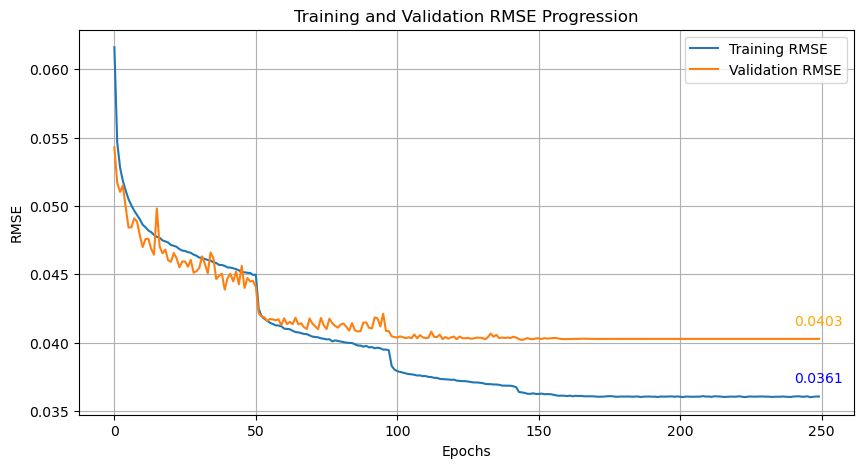

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses_tnn_small, label='Training RMSE')
plt.plot(val_losses_tnn_small, label='Validation RMSE')
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title(
    f"Training and Validation RMSE Progression")
plt.legend()
plt.grid(True)

LAST_TRAIN_RMSE = train_losses_tnn_small[-1]
LAST_VAL_RMSE = val_losses_tnn_small[-1]
# Annotations
plt.annotate(f"{LAST_TRAIN_RMSE:.4f}", (len(train_losses_tnn_small) - 1, train_losses_tnn_small[-1]), textcoords="offset points",
             xytext=(0, 10), ha='center', color='blue')
plt.annotate(f"{LAST_VAL_RMSE:.4f}", (len(val_losses_tnn_small) - 1, val_losses_tnn_small[-1]), textcoords="offset points",
             xytext=(0, 10), ha='center', color='orange')
plt.show()
#plt.savefig(pwd+"/Plots/training_prog.png", dpi=400)

### Import the big TNN model

In [17]:
model_path = 'RESULTS/model_checkpoint_big_v1.pth'
additional_features_dim = 4
context_size = 2
d_model = 512
context_dim = d_model
input_dim = 2
nhead = 8
num_encoder_layers = 4
dropout = 0.00
lr = 0.0001
num_epochs = 500

# Initialize model
model_tnn_big = contextDOAEncoder4(input_dim=input_dim, context_size=context_size,
                           additional_features_dim=additional_features_dim, d_model=d_model, nhead=nhead,
                           num_encoder_layers=num_encoder_layers, dropout=dropout).to(device)

# Load the saved weights
checkpoint = torch.load(model_path, map_location="mps:0")
model_tnn_big.load_state_dict(checkpoint['model_state_dict'])
train_losses_tnn_big = checkpoint['train_losses']
val_losses_tnn_big = checkpoint['val_losses']
lr = checkpoint['learning_rates']
elapsed_time = checkpoint['elapsed_time']
print("Model loaded!")

Model loaded!


In [8]:
# Create model instance
total_params = count_parameters(model_tnn_big)
print(f"Total parameters: {total_params}")

Total parameters: 12613122


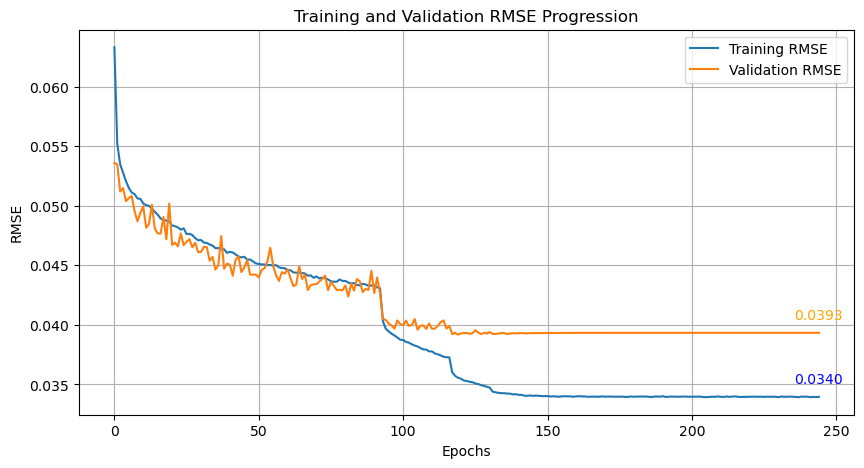

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses_tnn_big, label='Training RMSE')
plt.plot(val_losses_tnn_big, label='Validation RMSE')
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title(
    f"Training and Validation RMSE Progression")
plt.legend()
plt.grid(True)

LAST_TRAIN_RMSE = train_losses_tnn_big[-1]
LAST_VAL_RMSE = val_losses_tnn_big[-1]
# Annotations
plt.annotate(f"{LAST_TRAIN_RMSE:.4f}", (len(train_losses_tnn_big) - 1, train_losses_tnn_big[-1]), textcoords="offset points",
             xytext=(0, 10), ha='center', color='blue')
plt.annotate(f"{LAST_VAL_RMSE:.4f}", (len(val_losses_tnn_big) - 1, val_losses_tnn_big[-1]), textcoords="offset points",
             xytext=(0, 10), ha='center', color='orange')
plt.show()
#plt.savefig(pwd+"/Plots/training_prog.png", dpi=400)


## Angular accuracy testing
### Import test Dataset and prepare data

In [1]:
import random
import time
from scipy.io import loadmat
# Dataset preparation
window_size = 5
step_ahead = 1
data = loadmat('Dataset/test_dataset.mat')
block_dataset = data['out']
print(f"Imported Dataset of shape:[{block_dataset.shape[0]} x {block_dataset.shape[1]} x {block_dataset.shape[2]}]")


block_dataset = add_nlos_feature(block_dataset)
block_dataset = torch.from_numpy(block_dataset).float()

# Angles
denorm_az = torch.tensor([-89.99993133544922, 89.99988555908203])
denorm_el = torch.tensor([-63.164306640625, 58.51708221435547])

block_dataset[:,:,0] = normalize_data(block_dataset[:,:,0], -89.99993133544922, 89.99988555908203)
block_dataset[:,:,1] = normalize_data(block_dataset[:,:,1],-63.164306640625, 58.51708221435547)
# Velocities
min_value, max_value = -22.083147048950195, 22.39622688293457
block_dataset[:,:,2] = normalize_data(block_dataset[:,:,2], min_value, max_value)

min_value, max_value = -17.6036434173584, 17.59757423400879
block_dataset[:,:,3] = normalize_data(block_dataset[:,:,3], min_value, max_value)

# Accelerations
min_value, max_value = -33.608055114746094, 33.583335876464844
block_dataset[:,:,4] = normalize_data(block_dataset[:,:,4], min_value, max_value)

min_value, max_value = -26.34954833984375, 26.35047149658203
block_dataset[:,:,5] = normalize_data(block_dataset[:,:,5], min_value, max_value)

# VALSET IS THE TESTSET
valset = block_dataset

Imported Dataset of shape:[188143 x 6 x 6]
Data normalization in range [-89.99993133544922, 89.99988555908203]...
Data normalization in range [-63.164306640625, 58.51708221435547]...
Data normalization in range [-22.083147048950195, 22.39622688293457]...
Data normalization in range [-17.6036434173584, 17.59757423400879]...
Data normalization in range [-33.608055114746094, 33.583335876464844]...
Data normalization in range [-26.34954833984375, 26.35047149658203]...


### Keep the pedestrian paths only

In [261]:
tmp_set = valset
# Pedestrians only
valset = tmp_set[:114749]

# Cars only
#valset = tmp_set[114749:]

In [2]:
# Shuffle Validation set
valset = valset[torch.randperm(valset.shape[0])]
val_dataset = DOADataset(valset,device)

n_avg = valset.shape[0]
seq_len = 5

print("Done!")

Done!


In [16]:
# Models in Eval mode
model_tnn_small.eval()
model_tnn_big.eval()

contextDOAEncoder4(
  (input_proj): Linear(in_features=2, out_features=256, bias=True)
  (extended_context_embedding): ExtendedContextualEmbedding2(
    (binary_embedding): Embedding(2, 256)
    (continuous_projection): Linear(in_features=4, out_features=256, bias=True)
  )
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (transformer_encoder): CustomTransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x CustomTransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropou

## Statistical analysis on the small model

In [7]:
stopwatch = []
ang_dis_small = []
n_avg = 50000
for idx in range(n_avg):
    input = val_dataset.src_data[idx,0:seq_len,:input_dim]
    context = val_dataset.src_data[idx,0:seq_len,6].int()
    cont_feat = val_dataset.src_data[idx,0:seq_len,input_dim:6]
    #print(input)
    yhat = val_dataset.tgt_data[idx,seq_len-1,:2]
    yhat_az = denormalize_data(yhat[0],denorm_az[0],denorm_az[1])
    yhat_el = denormalize_data(yhat[1],denorm_el[0],denorm_el[1])
    tic = time.time()
    out_small = model_tnn_small(input, context, cont_feat) # Forward pass
    toc = time.time()-tic
    out_az = denormalize_data(out_small[0],denorm_az[0],denorm_az[1])
    out_el = denormalize_data(out_small[1],denorm_el[0],denorm_el[1])
    stopwatch.append(toc)
    #print(f"Before yhat (az,el): ({yhat_az},{yhat_el})")
    #print(f"Before out_small (az,el): ({out_az},{out_el})")
    yhat_az,yhat_el = inverse_transform_elevation_azimuth(yhat_az.cpu().item(),yhat_el.cpu().item())
    out_az,out_el = inverse_transform_elevation_azimuth(out_az.detach().cpu().item(),out_el.detach().cpu().item())
    #print(f"After yhat (az,el): ({yhat_az},{yhat_el})")
    #print(f"After out_small (az,el): ({out_az},{out_el})")
    ang_dis_small.append(angular_distance_3D(yhat_el,out_el,yhat_az,out_az))
    #print(f"Ang dis: {ang_dis_small[-1]}\n")

stopwatch = np.array(stopwatch)
ang_dis_small = np.array(ang_dis_small)
#print("INPUT:",input)
#print("YHAT:",yhat)
#print(f"OUT: {out_small}")
print(f'(Example) \nLast Input path: ')
for aoa in input:
    ell = denormalize_data(aoa[1],denorm_el[0],denorm_el[1])
    azz = denormalize_data(aoa[0],denorm_az[0],denorm_az[1])
    azz,ell = inverse_transform_elevation_azimuth(azz.cpu().item(),ell.cpu().item())
    print(f" (EL:{ell:.2f}, AZ: {azz:.2f})")
print(f"Target DOAS: EL:{yhat_el}, AZ:{yhat_az}")
print(f"Predicted DOAS: EL:{out_el}, AZ:{out_az}")

print(f"Angular Distance:\nmean:{ang_dis_small.mean():.2f} deg | std:{ang_dis_small.std():.2f} deg | \nAvg Response Time: mean: {stopwatch.mean()*1e3:.2f} msec | std: {stopwatch.std()*1e3:.2f} msec")

(Example) 
Last Input path: 
 (EL:4.39, AZ: 327.78)
 (EL:4.64, AZ: 314.15)
 (EL:4.92, AZ: 303.10)
 (EL:5.10, AZ: 294.29)
 (EL:5.05, AZ: 287.14)
Target DOAS: EL:4.6753387451171875, AZ:281.16973876953125
Predicted DOAS: EL:4.551002502441406, AZ:278.6373977661133
Angular Distance:
mean:1.60 deg | std:2.75 deg | 
Avg Response Time: mean: 2.76 msec | std: 0.82 msec


## Statistical analysis on the big model

In [8]:
stopwatch = []
ang_dis_big = []
for idx in range(n_avg):
    input = val_dataset.src_data[idx,0:seq_len,:input_dim]
    context = val_dataset.src_data[idx,0:seq_len,6].int()
    cont_feat = val_dataset.src_data[idx,0:seq_len,input_dim:6]
    #print(input)
    yhat = val_dataset.tgt_data[idx,seq_len-1,:2]
    yhat_az = denormalize_data(yhat[0],denorm_az[0],denorm_az[1])
    yhat_el = denormalize_data(yhat[1],denorm_el[0],denorm_el[1])
    tic = time.time()
    out_big = model_tnn_big(input, context, cont_feat) # Forward pass
    toc = time.time()-tic
    out_az = denormalize_data(out_big[0],denorm_az[0],denorm_az[1])
    out_el = denormalize_data(out_big[1],denorm_el[0],denorm_el[1])
    stopwatch.append(toc)
    #print(f"Before yhat (az,el): ({yhat_az},{yhat_el})")
    #print(f"Before out_big (az,el): ({out_az},{out_el})")
    yhat_az,yhat_el = inverse_transform_elevation_azimuth(yhat_az.cpu().item(),yhat_el.cpu().item())
    out_az,out_el = inverse_transform_elevation_azimuth(out_az.detach().cpu().item(),out_el.detach().cpu().item())
    #print(f"After yhat (az,el): ({yhat_az},{yhat_el})")
    #print(f"After out_big (az,el): ({out_az},{out_el})")
    ang_dis_big.append(angular_distance_3D(yhat_el,out_el,yhat_az,out_az))
    #print(f"Ang dis: {ang_dis[-1]}\n")

stopwatch = np.array(stopwatch)
ang_dis_big = np.array(ang_dis_big)
#print("INPUT:",input)
#print("YHAT:",yhat)
#print(f"OUT: {out_big}")
print(f'Input path: ')
for aoa in input:
    ell = denormalize_data(aoa[1],denorm_el[0],denorm_el[1])
    azz = denormalize_data(aoa[0],denorm_az[0],denorm_az[1])
    azz,ell = inverse_transform_elevation_azimuth(azz.cpu().item(),ell.cpu().item())
    print(f" (EL:{ell:.2f}, AZ: {azz:.2f})")
print(f"YHAT: EL:{yhat_el}, AZ:{yhat_az}")
print(f"OUT: EL:{out_el}, AZ:{out_az}")

print(f"Angular Distance:\nmean:{ang_dis_big.mean():.2f} deg | std:{ang_dis_big.std():.2f} deg | \nAvg Response Time: mean: {stopwatch.mean()*1e3:.2f} msec | std: {stopwatch.std()*1e3:.2f} msec")

Input path: 
 (EL:4.39, AZ: 327.78)
 (EL:4.64, AZ: 314.15)
 (EL:4.92, AZ: 303.10)
 (EL:5.10, AZ: 294.29)
 (EL:5.05, AZ: 287.14)
YHAT: EL:4.6753387451171875, AZ:281.16973876953125
OUT: EL:5.201713562011719, AZ:279.0814437866211
Angular Distance:
mean:1.55 deg | std:2.56 deg | 
Avg Response Time: mean: 3.36 msec | std: 0.43 msec


# Box plot comparison

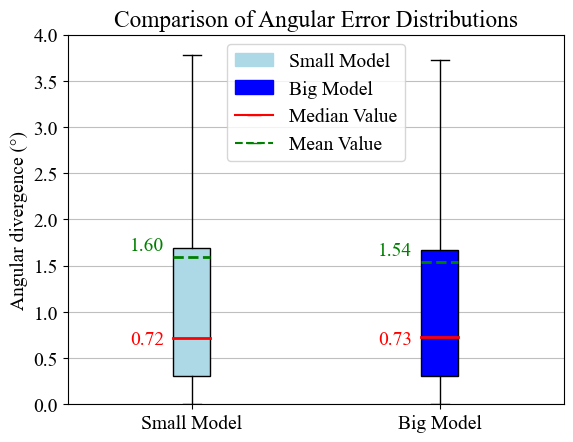

In [358]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.scale import FuncScale

# Define a function and its inverse for square root scaling
def forward(x):
    return np.sqrt(x)

def inverse(x):
    return x**2

# Assuming ang_dis_small and ang_dis_big are defined as some arrays.
# Example:
# ang_dis_small = np.random.gamma(2., 2., 100)
# ang_dis_big = np.random.gamma(2., 3., 100)

data = [ang_dis_small, ang_dis_big]  # Using only the first two data arrays
labels = ['Small Model', 'Big Model']  # Corresponding labels for two datasets only

# Creating the boxplot
fig, ax = plt.subplots()
bp = ax.boxplot(data, vert=True, patch_artist=True, labels=labels, showmeans=True,
                meanline=True, meanprops={'color': 'green', 'linestyle': '--', 'linewidth': 2},
                medianprops={'color': 'red', 'linestyle': '-', 'linewidth': 2},
                flierprops={'marker': ''})  # Outliers are not shown

# Adding colors for each box
colors = ['#ADD8E6', '#0000FF']  # Colors for two datasets
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Apply square root scale to the y-axis
#ax.set_yscale('function', functions=(forward, inverse))
# Adding grid lines aligned with the y-axis ticks
ax.yaxis.grid(True, linestyle='-', which='both', color='gray', alpha=0.5)

# Adding median value annotations to the left of each boxplot
medians = [np.median(d) for d in data]
means = [np.mean(d) for d in data]
for i, (median, mean) in enumerate(zip(medians, means)):
    ax.annotate(f'{median:.2f}', xy=(i+1, median), xytext=(-20, -5),
                textcoords='offset points', ha='right', color='red')  # Text is red for median
    ax.annotate(f'{mean:.2f}', xy=(i+1, mean), xytext=(-20, 5),
                textcoords='offset points', ha='right', color='green')  # Text is green for mean

# Adding legend by creating custom patches
patch1 = mpatches.Patch(color='#ADD8E6', label='Small Model')
patch2 = mpatches.Patch(color='#0000FF', label='Big Model')
median_line = mlines.Line2D([], [], color='red', marker='_', markersize=10, label='Median Value', linestyle='-')
mean_line = mlines.Line2D([], [], color='green', marker='_', markersize=10, label='Mean Value', linestyle='--')
plt.legend(handles=[patch1, patch2, median_line, mean_line], loc='upper center')

# Labeling the axes
ax.set_ylabel('Angular divergence (°)')

ax.set_title('Comparison of Angular Error Distributions')
plt.ylim([0,4])
# Show and save the plot
plt.savefig("Plots/ang_dis_comp.pdf", format='pdf', bbox_inches='tight', dpi=600)  # Save with high resolution
plt.show()


# Different lengths

In [9]:
from tqdm import tqdm
len_ang_dis_small = []
seq_lens = [1, 2, 3, 4, 5]
n_avg = 50000
for seq_len in seq_lens:
    print(f"\nSeq Length: {seq_len}")
    stopwatch = []
    ang_dis_small = []
    for idx in tqdm(range(n_avg), desc="Processing"):
        input = val_dataset.src_data[idx,0:seq_len,:input_dim]
        context = val_dataset.src_data[idx,0:seq_len,6].int()
        cont_feat = val_dataset.src_data[idx,0:seq_len,input_dim:6]
        #print(input)
        yhat = val_dataset.tgt_data[idx,seq_len-1,:2]
        yhat_az = denormalize_data(yhat[0],denorm_az[0],denorm_az[1])
        yhat_el = denormalize_data(yhat[1],denorm_el[0],denorm_el[1])
        tic = time.time()
        out_small = model_tnn_small(input, context, cont_feat) # Forward pass
        toc = time.time()-tic
        out_az = denormalize_data(out_small[0],denorm_az[0],denorm_az[1])
        out_el = denormalize_data(out_small[1],denorm_el[0],denorm_el[1])
        stopwatch.append(toc)
        #print(f"Before yhat (az,el): ({yhat_az},{yhat_el})")
        #print(f"Before out_small (az,el): ({out_az},{out_el})")
        yhat_az,yhat_el = inverse_transform_elevation_azimuth(yhat_az.cpu().item(),yhat_el.cpu().item())
        out_az,out_el = inverse_transform_elevation_azimuth(out_az.detach().cpu().item(),out_el.detach().cpu().item())
        #print(f"After yhat (az,el): ({yhat_az},{yhat_el})")
        #print(f"After out_small (az,el): ({out_az},{out_el})")
        ang_dis_small.append(angular_distance_3D(yhat_el,out_el,yhat_az,out_az))
        #print(f"Ang dis: {ang_dis_small[-1]}\n")

    stopwatch = np.array(stopwatch)
    ang_dis_small = np.array(ang_dis_small)
    #print("INPUT:",input)
    #print("YHAT:",yhat)
    #print(f"OUT: {out_small}")
    print(f'Input path: ')
    for aoa in input:
        ell = denormalize_data(aoa[1],denorm_el[0],denorm_el[1])
        azz = denormalize_data(aoa[0],denorm_az[0],denorm_az[1])
        azz,ell = inverse_transform_elevation_azimuth(azz.cpu().item(),ell.cpu().item())
        print(f" (EL:{ell:.2f}, AZ: {azz:.2f})")
    print(f"YHAT: EL:{yhat_el}, AZ:{yhat_az}")
    print(f"OUT: EL:{out_el}, AZ:{out_az}")

    print(f"Angular Distance:\nmean:{ang_dis_small.mean():.2f} deg | std:{ang_dis_small.std():.2f} deg | \nAvg Response Time: mean: {stopwatch.mean()*1e3:.2f} msec | std: {stopwatch.std()*1e3:.2f} msec")
    len_ang_dis_small.append(ang_dis_small)


Seq Length: 1


Processing: 100%|██████████| 50000/50000 [03:39<00:00, 227.52it/s]


Input path: 
 (EL:34.54, AZ: 112.10)
YHAT: EL:34.40283966064453, AZ:112.12105560302734
OUT: EL:36.49896240234375, AZ:109.13919830322266
Angular Distance:
mean:2.92 deg | std:2.35 deg | 
Avg Response Time: mean: 2.58 msec | std: 0.32 msec

Seq Length: 2


Processing: 100%|██████████| 50000/50000 [04:57<00:00, 168.27it/s]


Input path: 
 (EL:34.54, AZ: 112.10)
 (EL:34.40, AZ: 112.12)
YHAT: EL:34.27777862548828, AZ:112.12438201904297
OUT: EL:35.72643280029297, AZ:110.17365264892578
Angular Distance:
mean:2.36 deg | std:2.89 deg | 
Avg Response Time: mean: 2.93 msec | std: 8.40 msec

Seq Length: 3


Processing: 100%|██████████| 50000/50000 [05:56<00:00, 140.38it/s]


Input path: 
 (EL:34.54, AZ: 112.10)
 (EL:34.40, AZ: 112.12)
 (EL:34.28, AZ: 112.12)
YHAT: EL:34.14873123168945, AZ:112.13750457763672
OUT: EL:34.98521423339844, AZ:110.7582015991211
Angular Distance:
mean:1.85 deg | std:2.83 deg | 
Avg Response Time: mean: 3.34 msec | std: 7.23 msec

Seq Length: 4


Processing: 100%|██████████| 50000/50000 [05:49<00:00, 143.03it/s]


Input path: 
 (EL:34.54, AZ: 112.10)
 (EL:34.40, AZ: 112.12)
 (EL:34.28, AZ: 112.12)
 (EL:34.15, AZ: 112.14)
YHAT: EL:34.1277961730957, AZ:112.05101776123047
OUT: EL:34.35694885253906, AZ:111.5762710571289
Angular Distance:
mean:1.66 deg | std:2.78 deg | 
Avg Response Time: mean: 3.34 msec | std: 7.08 msec

Seq Length: 5


Processing: 100%|██████████| 50000/50000 [05:54<00:00, 140.98it/s]


Input path: 
 (EL:34.54, AZ: 112.10)
 (EL:34.40, AZ: 112.12)
 (EL:34.28, AZ: 112.12)
 (EL:34.15, AZ: 112.14)
 (EL:34.13, AZ: 112.05)
YHAT: EL:34.04401397705078, AZ:112.01355743408203
OUT: EL:34.23480987548828, AZ:111.95833587646484
Angular Distance:
mean:1.60 deg | std:2.73 deg | 
Avg Response Time: mean: 3.23 msec | std: 2.05 msec


In [10]:
len_ang_dis_big = []
seq_lens = [1, 2, 3, 4, 5]
n_avg = 50000
for seq_len in seq_lens:
    print(f"\nSeq Length: {seq_len}")
    stopwatch = []
    ang_dis_big = []
    for idx in tqdm(range(n_avg), desc="Processing"):
        input = val_dataset.src_data[idx,0:seq_len,:input_dim]
        context = val_dataset.src_data[idx,0:seq_len,6].int()
        cont_feat = val_dataset.src_data[idx,0:seq_len,input_dim:6]
        #print(input)
        yhat = val_dataset.tgt_data[idx,seq_len-1,:2]
        yhat_az = denormalize_data(yhat[0],denorm_az[0],denorm_az[1])
        yhat_el = denormalize_data(yhat[1],denorm_el[0],denorm_el[1])
        tic = time.time()
        out_big = model_tnn_big(input, context, cont_feat) # Forward pass
        toc = time.time()-tic
        out_az = denormalize_data(out_big[0],denorm_az[0],denorm_az[1])
        out_el = denormalize_data(out_big[1],denorm_el[0],denorm_el[1])
        stopwatch.append(toc)
        #print(f"Before yhat (az,el): ({yhat_az},{yhat_el})")
        #print(f"Before out_big (az,el): ({out_az},{out_el})")
        yhat_az,yhat_el = inverse_transform_elevation_azimuth(yhat_az.cpu().item(),yhat_el.cpu().item())
        out_az,out_el = inverse_transform_elevation_azimuth(out_az.detach().cpu().item(),out_el.detach().cpu().item())
        #print(f"After yhat (az,el): ({yhat_az},{yhat_el})")
        #print(f"After out_big (az,el): ({out_az},{out_el})")
        ang_dis_big.append(angular_distance_3D(yhat_el,out_el,yhat_az,out_az))
        #print(f"Ang dis: {ang_dis[-1]}\n")

    stopwatch = np.array(stopwatch)
    ang_dis_big = np.array(ang_dis_big)
    #print("INPUT:",input)
    #print("YHAT:",yhat)
    #print(f"OUT: {out_big}")
    print(f'Input path: ')
    for aoa in input:
        ell = denormalize_data(aoa[1],denorm_el[0],denorm_el[1])
        azz = denormalize_data(aoa[0],denorm_az[0],denorm_az[1])
        azz,ell = inverse_transform_elevation_azimuth(azz.cpu().item(),ell.cpu().item())
        print(f" (EL:{ell:.2f}, AZ: {azz:.2f})")
    print(f"YHAT: EL:{yhat_el}, AZ:{yhat_az}")
    print(f"OUT: EL:{out_el}, AZ:{out_az}")

    print(f"Angular Distance:\nmean:{ang_dis_big.mean():.2f} deg | std:{ang_dis_big.std():.2f} deg | \nAvg Response Time: mean: {stopwatch.mean()*1e3:.2f} msec | std: {stopwatch.std()*1e3:.2f} msec")
    len_ang_dis_big.append(ang_dis_big)


Seq Length: 1


Processing: 100%|██████████| 50000/50000 [06:26<00:00, 129.51it/s]


Input path: 
 (EL:34.54, AZ: 112.10)
YHAT: EL:34.40283966064453, AZ:112.12105560302734
OUT: EL:33.88344955444336, AZ:113.96871185302734
Angular Distance:
mean:1.65 deg | std:2.15 deg | 
Avg Response Time: mean: 3.91 msec | std: 2.77 msec

Seq Length: 2


Processing: 100%|██████████| 50000/50000 [06:39<00:00, 125.10it/s]


Input path: 
 (EL:34.54, AZ: 112.10)
 (EL:34.40, AZ: 112.12)
YHAT: EL:34.27777862548828, AZ:112.12438201904297
OUT: EL:34.3271598815918, AZ:113.29936981201172
Angular Distance:
mean:1.57 deg | std:2.32 deg | 
Avg Response Time: mean: 4.08 msec | std: 2.25 msec

Seq Length: 3


Processing: 100%|██████████| 50000/50000 [04:52<00:00, 170.80it/s]


Input path: 
 (EL:34.54, AZ: 112.10)
 (EL:34.40, AZ: 112.12)
 (EL:34.28, AZ: 112.12)
YHAT: EL:34.14873123168945, AZ:112.13750457763672
OUT: EL:34.58721923828125, AZ:112.82967376708984
Angular Distance:
mean:1.66 deg | std:2.40 deg | 
Avg Response Time: mean: 3.57 msec | std: 1.68 msec

Seq Length: 4


Processing: 100%|██████████| 50000/50000 [06:26<00:00, 129.20it/s]


Input path: 
 (EL:34.54, AZ: 112.10)
 (EL:34.40, AZ: 112.12)
 (EL:34.28, AZ: 112.12)
 (EL:34.15, AZ: 112.14)
YHAT: EL:34.1277961730957, AZ:112.05101776123047
OUT: EL:34.510032653808594, AZ:112.61023712158203
Angular Distance:
mean:1.64 deg | std:2.56 deg | 
Avg Response Time: mean: 3.86 msec | std: 10.73 msec

Seq Length: 5


Processing: 100%|██████████| 50000/50000 [07:14<00:00, 114.95it/s]


Input path: 
 (EL:34.54, AZ: 112.10)
 (EL:34.40, AZ: 112.12)
 (EL:34.28, AZ: 112.12)
 (EL:34.15, AZ: 112.14)
 (EL:34.13, AZ: 112.05)
YHAT: EL:34.04401397705078, AZ:112.01355743408203
OUT: EL:34.2130241394043, AZ:112.47891998291016
Angular Distance:
mean:1.53 deg | std:2.52 deg | 
Avg Response Time: mean: 3.82 msec | std: 2.04 msec


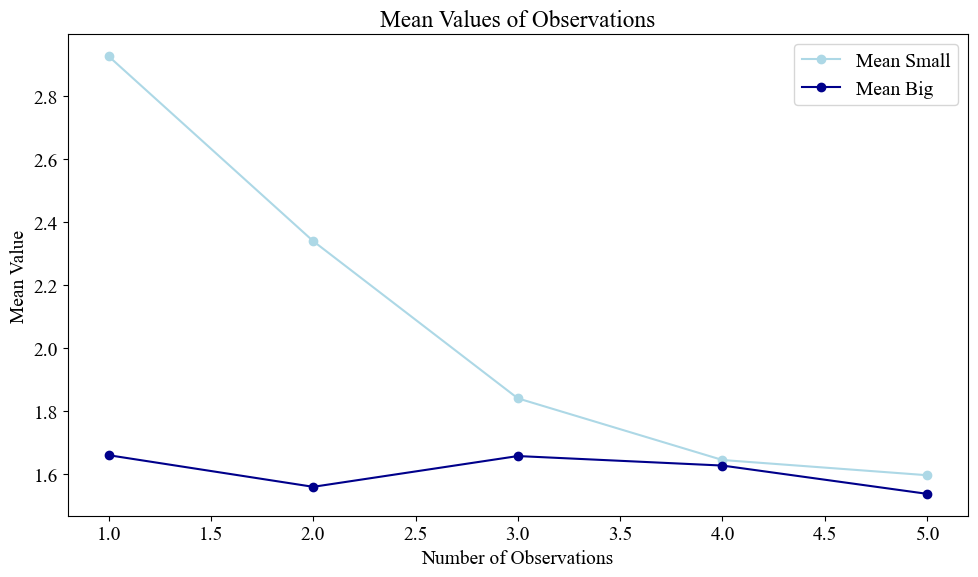

In [296]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Assuming len_ang_dis_small and len_ang_dis_big are defined somewhere in your script
# Example initialization if needed:
# len_ang_dis_small = [np.random.normal(loc=2, scale=1, size=100) for _ in range(5)]
# len_ang_dis_big = [np.random.normal(loc=5, scale=1.5, size=100) for _ in range(5)]

# Set the font to Times New Roman
mpl.rcParams['font.family'] = 'Times New Roman'

# Create a figure and a single axes
fig, ax = plt.subplots(figsize=(10, 6))

# Compute the mean of each array
means_small = [np.mean(arr) for arr in len_ang_dis_small]
means_big = [np.mean(arr) for arr in len_ang_dis_big]

# Generate a series of indices (1-based) for x-axis
indices = np.arange(1, len(means_small) + 1)

# Plot the mean curves
ax.plot(indices, means_small, marker='o', color='lightblue', label='Mean Small')
ax.plot(indices, means_big, marker='o', color='darkblue', label='Mean Big')

# Set labels and title
ax.set_xlabel("Number of Observations")
ax.set_ylabel("Mean Value")
ax.set_title("Mean Values of Observations")

# Set y-axis scale to square root and limit
ax.set_yscale('linear')  # For mean values, linear scale may be more appropriate

# Adding a legend
ax.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
